In [1]:
import pickle
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,  confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Create a pipeline that will scale the numerical data and then feed the resulting data into a decision tree

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
import umap
from imblearn.datasets import make_imbalance

In [2]:
with open('/global/cscratch1/sd/alazar/fedLearn/pfile/train.pk', 'rb') as f:
    X,y = pickle.load(f)
with open('/global/cscratch1/sd/alazar/fedLearn/pfile/test.pk', 'rb') as f:
    X_test,y_test = pickle.load(f)

In [3]:
scaler = MinMaxScaler()
#scaler = StandardScaler()
scaler.fit(X)
X_scaled=scaler.transform(X)
X_test_scaled=scaler.transform(X_test)

In [59]:
import pickle
with open('/global/cscratch1/sd/alazar/fedLearn/pfile/test_scaled.sav', 'wb') as f:
    pickle.dump([X_test_scaled,y_test], f)

In [61]:
np.unique(y, return_counts=True)

(array(['flooding', 'impersonation', 'injection', 'normal'], dtype=object),
 array([  48484,   48522,   65379, 1177021]))

In [4]:
data = np.array(np.vstack([X_scaled, X_test_scaled]), dtype=np.float64)
target = np.hstack([y, y_test])
np.unique(target, return_counts=True)
X_rs, y_rs = make_imbalance(data, target, sampling_strategy={'normal':205285, 'injection':82061, 'impersonation':68601, 'flooding':54623},random_state=0)                       

In [5]:
data=X_rs
target=y_rs
encoder = LabelEncoder()
encoded_target = encoder.fit_transform(target)
encoded_target

array([0, 0, 0, ..., 3, 3, 3])

In [64]:
np.unique(y_rs, return_counts=True)

(array(['flooding', 'impersonation', 'injection', 'normal'], dtype=object),
 array([ 54623,  68601,  82061, 205285]))

In [6]:
import pickle
#with open('/global/cscratch1/sd/alazar/fedLearn/pfile/all_data.sav', 'wb') as f:
with open('/global/cscratch1/sd/alazar/leaf/data/awid/all_data.sav', 'wb') as f:
    pickle.dump([X_rs,encoded_target], f)

In [43]:
%%time
embedding = umap.UMAP(n_neighbors=10).fit_transform(data, y=encoded_target)

/global/homes/a/alazar/.conda/envs/fedenv/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 572 separate connected components using meta-embedding (experimental)
  n_components


CPU times: user 22min 55s, sys: 11.6 s, total: 23min 6s
Wall time: 16min 26s


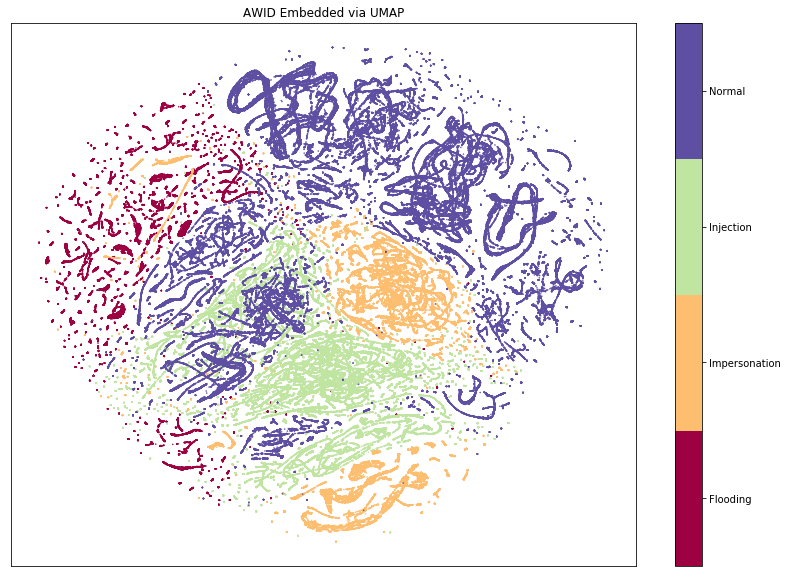

In [45]:
classes = [
    'Flooding',
    'Impersonation',
    'Injection',
    'Normal']
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.3, c=encoded_target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(5)-0.5)
cbar.set_ticks(np.arange(4))
cbar.set_ticklabels(classes)
plt.title('AWID Embedded via UMAP');

In [47]:
X_rs, y_rs = make_imbalance(X_scaled, y, sampling_strategy={'normal':162385, 'injection':65379, 'impersonation':48522, 'flooding':48484},random_state=0)                       

In [58]:
import pickle
with open('/global/cscratch1/sd/alazar/fedLearn/pfile/train_rs.sav', 'wb') as f:
    pickle.dump([X_rs,y_rs], f)

In [48]:
# do a basic naive bayes fitting
nb = GaussianNB()

# fit our model to the data
nb.fit(X_rs, y_rs)

GaussianNB(priors=None, var_smoothing=1e-09)

In [49]:
# simple function to test the accuracy of a model fitted on training data on our testing data
def get_test_accuracy_of(model):
    y_preds = model.predict(X_test_scaled)
    return accuracy_score(y_preds, y_test)
    
# naive abyes does very poorly on its own!
get_test_accuracy_of(nb)

0.8049565116846744

In [50]:
lr = LogisticRegression()

lr.fit(X_rs, y_rs)

# Logistic Regressions does even worse
get_test_accuracy_of(lr)

/global/homes/a/alazar/.conda/envs/fedenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/global/homes/a/alazar/.conda/envs/fedenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.8537328005961176

In [51]:
tree = DecisionTreeClassifier()

tree.fit(X_rs, y_rs)

# Tree does very well!
get_test_accuracy_of(tree)

0.9327620540359983

In [52]:
forest = RandomForestClassifier()

forest.fit(X_rs, y_rs)

# Random Forest does slightly worse
get_test_accuracy_of(forest)

/global/homes/a/alazar/.conda/envs/fedenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9341110268895255

In [53]:
pipeline = Pipeline([
    ("classifier", DecisionTreeClassifier())
])

# try varying levels of depth
params = {
    "classifier__max_depth": [None, 3, 5, 10], 
         }

# instantiate a gridsearch module
grid = GridSearchCV(pipeline, params)
# fit the module
grid.fit(X_rs, y_rs)

# test the best model
get_test_accuracy_of(grid.best_estimator_)

/global/homes/a/alazar/.conda/envs/fedenv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.9340005395891414

In [54]:
encoder = LabelEncoder()
encoded_y = encoder.fit_transform(y_rs)
encoded_y.shape

(324770,)

In [55]:
binarizer = LabelBinarizer()
binarized_y = binarizer.fit_transform(encoded_y)
binarized_y.shape

(324770, 4)

In [56]:
# Baseline model for the neural network. We choose a hidden layer of 10 neurons. The lesser number of neurons helps to eliminate the redundancies in the data and select the more important features.
def create_baseline_model(n, input_dim):
    # create model
    model = Sequential()
    model.add(Dense(n, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
    model.add(Dense(4, kernel_initializer='normal', activation='softmax'))#'sigmoid'))
    # Compile model. We use the the logarithmic loss function, and the Adam gradient optimizer.
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [57]:
KerasClassifier(build_fn=create_baseline_model, epochs=100, batch_size=5, verbose=0, n=20)

NameError: name 'KerasClassifier' is not defined

In [94]:
# use the KerasClassifier

pipeline = Pipeline([
    ("classifier", KerasClassifier(build_fn=create_baseline_model, epochs=2, batch_size=128, 
                                   verbose=1, n=10, input_dim=74))
])

In [95]:
from sklearn.model_selection import cross_val_score
cross_val_score(pipeline, X_scaled, binarized_y)

Epoch 1/2
892937/892937 [==============================] - 10s 11us/step - loss: 0.1373 - acc: 0.9554
Epoch 2/2
446469/446469 [==============================] - 3s 6us/step
Epoch 1/2
892937/892937 [==============================] - 10s 11us/step - loss: 0.1659 - acc: 0.9509
Epoch 2/2
446469/446469 [==============================] - 3s 6us/step
Epoch 1/2
892938/892938 [==============================] - 10s 11us/step - loss: 0.0637 - acc: 0.9834
Epoch 2/2
446468/446468 [==============================] - 3s 6us/step


array([0.97312019, 0.98315001, 0.81990199])

In [96]:
pipeline.fit(X_scaled, binarized_y)

Epoch 1/2
1339406/1339406 [==============================] - 16s 12us/step - loss: 0.1059 - acc: 0.9662
Epoch 2/2
1339406/1339406 [==============================] - 15s 11us/step - loss: 0.0415 - acc: 0.9890


Pipeline(memory=None,
         steps=[('classifier',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x2aab1f5c1780>)],
         verbose=False)

In [97]:
# remake 
encoded_y_test = encoder.transform(y_test)
def get_network_test_accuracy_of(model):
    y_preds = model.predict(X_test_scaled)
    return accuracy_score(y_preds, encoded_y_test)

In [98]:
# not the best accuracy
get_network_test_accuracy_of(pipeline)

389185/389185 [==============================] - 2s 6us/step


0.8899572182895025

In [99]:
# change our function to have multiple hidden layers in our network
def network_builder(hidden_dimensions, input_dim):
    # create model
    model = Sequential()
    model.add(Dense(hidden_dimensions[0], input_dim=input_dim, kernel_initializer='normal', activation='relu'))
    # add multiple hidden layers
    for dimension in hidden_dimensions[1:]:
        model.add(Dense(dimension, kernel_initializer='normal', activation='relu'))
    model.add(Dense(4, kernel_initializer='normal', activation='softmax'))
    # Compile model. We use the the logarithmic loss function, and the Adam gradient optimizer.
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [107]:
# add some more hidden layers to learn more
pipeline = Pipeline([
    ("classifier", KerasClassifier(build_fn=network_builder, epochs=10, batch_size=128, 
                                   verbose=1, hidden_dimensions=(128,64,32), input_dim=74))
])

#cross_val_score(pipeline, X_scaled, binarized_y)

In [101]:
# remake 
encoded_y_test = encoder.transform(y_test)
def get_network_test_accuracy_of(model):
    y_preds = model.predict(X_test_scaled)
    return accuracy_score(y_preds, encoded_y_test)

In [11]:
encoded_y_test = encoder.transform(y_test)

In [108]:
pipeline.fit(X_scaled, binarized_y)
get_network_test_accuracy_of(pipeline)

Epoch 1/10
1339406/1339406 [==============================] - 24s 18us/step - loss: 0.0319 - acc: 0.9907
Epoch 2/10
1339406/1339406 [==============================] - 23s 17us/step - loss: 0.0077 - acc: 0.9976
Epoch 3/10
1339406/1339406 [==============================] - 23s 17us/step - loss: 0.0058 - acc: 0.9982
Epoch 4/10
1339406/1339406 [==============================] - 23s 17us/step - loss: 0.0048 - acc: 0.9986
Epoch 5/10
1339406/1339406 [==============================] - 23s 17us/step - loss: 0.0042 - acc: 0.9988
Epoch 6/10
1339406/1339406 [==============================] - 23s 17us/step - loss: 0.0039 - acc: 0.9989
Epoch 7/10
1339406/1339406 [==============================] - 23s 17us/step - loss: 0.0036 - acc: 0.9990
Epoch 8/10
1339406/1339406 [==============================] - 22s 16us/step - loss: 0.0035 - acc: 0.9990
Epoch 9/10
1339406/1339406 [==============================] - 21s 16us/step - loss: 0.0036 - acc: 0.9990
Epoch 10/10
389185/389185 [============================

0.88986214782173

In [109]:
y_preds = pipeline.predict(X_test_scaled)
y_preds

389185/389185 [==============================] - 3s 7us/step


array([3, 3, 3, ..., 3, 3, 3])

In [110]:
accuracy_score(y_preds, encoded_y_test)

0.88986214782173

In [113]:
 confusion_matrix(y_preds, encoded_y_test)

array([[     0,      0,      0,      0],
       [     0,      0,      0,      0],
       [     0,      0,     36,      0],
       [  6139,  20079,  16646, 346285]])